In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
!pip3.8 install fbm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import warnings
warnings.filterwarnings("ignore")

import glob
import shutil
import itertools
import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.utils import resample, shuffle

from localfinlab.clustering import *

cwd = os.getcwd()

np.set_printoptions(threshold=sys.maxsize)

In [4]:

from localfinlab.pairs_trading_backtester import (
    SeriesAnalyser, DataProcessor#, MPSeriesAnalyser, MPTrader, Trader
)
series_analyser = SeriesAnalyser()
data_processor = DataProcessor()

# load etf metadata
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(path='../sarmento-original-thesis/data/commodity_ETFs_long_updated.xlsx')

# load intraday prices (5minute interval)
df_prices = pd.read_pickle('../sarmento-original-thesis/data/pickle/commodity_ETFs_from_2014_complete.pickle')

SPLIT_IDX = 1

# train split, test split, train_val_split
splits = [ 
    [('01-01-2012', '31-12-2014'), ('01-01-2015', '31-12-2015'), '2014-01-01'],
    [('01-01-2013', '31-12-2015'), ('01-01-2016', '31-12-2016'), '2015-01-01'],
    [('01-01-2014', '31-12-2016'), ('01-01-2017', '31-12-2017'), '2016-01-01'] 
]

# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            splits[SPLIT_IDX][0],
                                                            splits[SPLIT_IDX][1],
                                                            remove_nan=True)
df_returns = data_processor.get_return_series(df_prices_train)

# del df_prices

Total of 116 tickers
Total of 105 tickers after removing tickers with Nan values


In [5]:
from numpy import zeros, mod
import statsmodels.api as sm
import scipy
from sklearn import metrics
import statsmodels.api as sm
from arch.unitroot import KPSS, DFGLS, PhillipsPerron, ZivotAndrews, VarianceRatio
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import RegressionResults
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet

def ols_me(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit().params#[0]
    
    # coef, intercept
    return model, results[1], results[0]

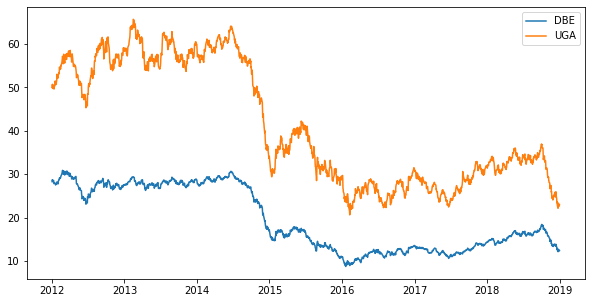

In [53]:
x = df_prices[['DBE']].resample('B', label='right', closed='right').last().dropna()
y = df_prices[['UGA']].resample('B', label='right', closed='right').last().dropna()

_, slope, intercept = ols_me(x, y)

fig, axs = plt.subplots(figsize=(10, 5), sharex=True)

axs.plot(x, label='DBE')
axs.plot(y, label='UGA')
axs.legend()
# plt.show()

# epsilon=y.values-intercept-slope*x.values

# df = pd.DataFrame(epsilon.reshape(1, -1)[0], index=x.index, columns=['spread'])

# axs[1].plot(df)##.plot()
# axs[1].hlines(y=np.std(epsilon.reshape(1, -1)[0]), xmin=x.index[0], xmax=x.index[-1], 
#               linestyle='dotted', label='$+\sigma$')
# axs[1].hlines(y=-np.std(epsilon.reshape(1, -1)[0]), xmin=x.index[0], xmax=x.index[-1], 
#               linestyle='dotted', label='$-\sigma$')
# axs[1].hlines(y=0, xmin=x.index[0], xmax=x.index[-1], color='r',
#               linestyle='dotted', label='$\mu$')
# axs[1].legend()
plt.show()


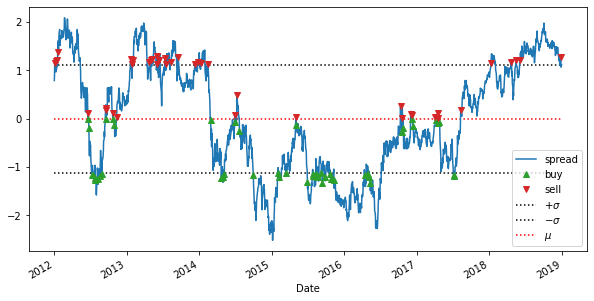

In [54]:
upper_bound = np.std(epsilon.reshape(1, -1)[0])
lower_bound = -np.std(epsilon.reshape(1, -1)[0])
mean_bound = 0

df['buy'] = df['spread'][((df['spread'] < lower_bound) & (df['spread'].shift(1) > lower_bound) | 
                          (df['spread'] <  mean_bound) & (df['spread'].shift(1) > mean_bound))]

df['sell'] = df['spread'][((df['spread'] > upper_bound) & (df['spread'].shift(1) < upper_bound) | 
                           (df['spread'] >  mean_bound) & (df['spread'].shift(1) <  mean_bound))]

fig, ax = plt.subplots(figsize=(10, 5), sharex=True)

ax.hlines(y=np.std(epsilon.reshape(1, -1)[0]), xmin=x.index[0], xmax=x.index[-1], 
              linestyle='dotted', label='$+\sigma$')
ax.hlines(y=-np.std(epsilon.reshape(1, -1)[0]), xmin=x.index[0], xmax=x.index[-1], 
              linestyle='dotted', label='$-\sigma$')
ax.hlines(y=0, xmin=x.index[0], xmax=x.index[-1], color='r',
              linestyle='dotted', label='$\mu$')

df.plot(ax=ax, style=['tab:blue', 'C2^','C3v'])
ax.legend();

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM

def generate_ou_ts(theta=0.7):

    f = FBM(n=1024, hurst=theta, length=1, method='daviesharte')
    fbm_sample = f.fbm()
    
    return fbm_sample

# plt.plot(t,y)
# plt.show()

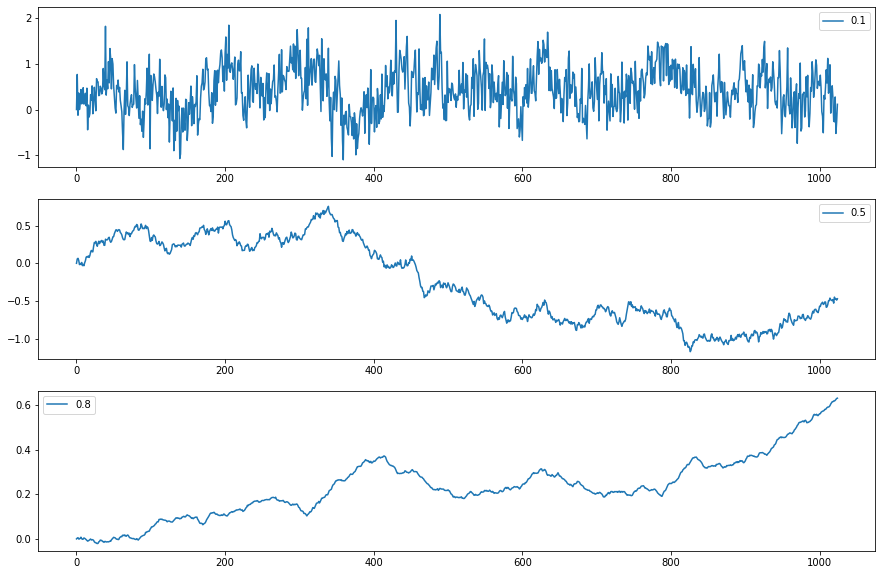

In [80]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

low_mr_y = generate_ou_ts(0.1)
axs[0].plot(pd.Series(low_mr_y), label='0.1')
axs[0].legend()

mid_mr_y = generate_ou_ts(0.5)
axs[1].plot(pd.Series(mid_mr_y), label='0.5')
axs[1].legend()

high_mr_y = generate_ou_ts(0.8)
axs[2].plot(pd.Series(high_mr_y), label='0.8')
axs[2].legend()

In [75]:
series_analyser.hurst(fbm_sample)

0.6687100793444932

In [56]:
# import requests
# from datetime import datetime
# from urllib.parse import parse_qsl, urljoin, urlparse
# from urllib.request import Request, urlopen
# import os
# from bs4 import BeautifulSoup
# import urllib
# from lxml import etree
# from xml.etree import ElementTree
# import json

# import time
# import os


# objs = []

# from datetime import date, timedelta

# yesterday = date.today() - timedelta(days=1)

# url = ("https://www.wsj.com/news/archive/" + yesterday.strftime('%Y%m%d'))

# r = urlopen(Request(url, headers={'User-Agent': 'Mozilla/5.0'}))
# tree = etree.HTML(r.read())

# articles = tree.xpath('//*[@id="main"]/div/div/ol/article')


In [57]:
# for a in articles:

#     print( a.findall('.//a')[0].get('href') )
    
#     # 	link = a.findall('.//a')[0].get('href')
# # 	article_type = a.findall('.//div/span')[0].text
# # 	if len(a.findall('.//div/h3/a')) != 0:
# # 		article_heading = a.findall('.//div/h3/a')[0].text

# # 		if len( a.findall('.//p') ) > 0:
# # 			article_summary = a.findall('.//p')[0].text
# # 		else:
# # 			article_summary = ""

# # 		objs.append({"link": link, "type": article_type, "heading": article_heading,
# # 		"summary": article_summary}) 


# # dir_path = os.path.dirname(os.path.realpath(__file__))

# # file_path = dir_path + '/articles/' + str(yesterday) + '.snapshot'


# # with open(file_path, "w") as w:
# # 	w.write( json.dumps(objs) )



In [58]:
# url = ("https://www.ft.com/content/7e59adbc-b9c6-45fd-8826-f4f02232fbfb")

# r = urlopen(Request(url, headers={'User-Agent': 'Mozilla/5.0', 'Referer': 'https://www.google.com/'}))
# html_source = r.read()
# tree = etree.HTML(html_source)

# # article_text = tree.xpath('//*[@id="main"]/div/div[1]/div[1]/div/div[5]')


In [59]:
# # article_text[0][0].text
# html_source

In [55]:
# html_source